# Imports

In [1]:
import csv
import numpy as np

# Helper Functions

In [2]:
"""Some helper functions for project 1."""
def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y == "b")] = -1

    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]

    return yb, input_data, ids


def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in .csv format for submission to Kaggle or AIcrowd
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, "w") as csvfile:
        fieldnames = ["Id", "Prediction"]
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({"Id": int(r1), "Prediction": int(r2)})

# Test Functions

In [3]:
RTOL=1e-4
ATOL=1e-8

MAX_ITERS = 2
GAMMA = 0.1

def initial_w_testing():
    return np.array([[0.5], [1.0]])

def y_testing():
    return np.array([[0.1], [0.3], [0.5]])

def tx_testing():
    return np.array([[2.3, 3.2], [1.0, 0.1], [1.4, 2.3]])

def test_least_squares(y, tx):
    w, loss = least_squares(y, tx)

    expected_w = np.array([[0.218786], [-0.053837]])
    expected_loss = 0.026942

    np.testing.assert_allclose(w, expected_w, rtol=RTOL, atol=ATOL)
    np.testing.assert_allclose(loss, expected_loss, rtol=RTOL, atol=ATOL)
    assert loss.ndim == 0
    assert w.shape == expected_w.shape


def test_ridge_regression_lambda0(y, tx):
    lambda_ = 0.0
    w, loss = ridge_regression(y, tx, lambda_)

    expected_loss = 0.026942
    expected_w = np.array([[0.218786], [-0.053837]])

    np.testing.assert_allclose(w, expected_w, rtol=RTOL, atol=ATOL)
    np.testing.assert_allclose(loss, expected_loss, rtol=RTOL, atol=ATOL)
    assert loss.ndim == 0
    assert w.shape == expected_w.shape


def test_ridge_regression_lambda1(y, tx):
    lambda_ = 1.0
    w, loss = ridge_regression(y, tx, lambda_)

    expected_loss = 0.03175
    expected_w = np.array([[0.054303], [0.042713]])

    np.testing.assert_allclose(loss, expected_loss, rtol=RTOL, atol=ATOL)
    np.testing.assert_allclose(w, expected_w, rtol=RTOL, atol=ATOL)
    assert loss.ndim == 0
    assert w.shape == expected_w.shape


def test_logistic_regression_0_step(y, tx):
    expected_w = np.array([[0.463156], [0.939874]])
    y = (y > 0.2) * 1.0
    w, loss = logistic_regression(y, tx, expected_w, 0, GAMMA)

    expected_loss = 1.533694

    np.testing.assert_allclose(loss, expected_loss, rtol=RTOL, atol=ATOL)
    np.testing.assert_allclose(w, expected_w, rtol=RTOL, atol=ATOL)
    assert loss.ndim == 0
    assert w.shape == expected_w.shape


def test_logistic_regression(y, tx, initial_w):
    y = (y > 0.2) * 1.0
    w, loss = logistic_regression(
        y, tx, initial_w, MAX_ITERS, GAMMA
    )

    expected_loss = 1.348358
    expected_w = np.array([[0.378561], [0.801131]])

    np.testing.assert_allclose(loss, expected_loss, rtol=RTOL, atol=ATOL)
    np.testing.assert_allclose(w, expected_w, rtol=RTOL, atol=ATOL)
    assert loss.ndim == 0
    assert w.shape == expected_w.shape
    
def test_reg_logistic_regression(y, tx, initial_w):
    lambda_ = 1.0
    y = (y > 0.2) * 1.0
    w, loss = reg_logistic_regression(
        y, tx, lambda_, initial_w, MAX_ITERS, GAMMA
    )

    expected_loss = 0.972165
    expected_w = np.array([[0.216062], [0.467747]])

    np.testing.assert_allclose(loss, expected_loss, rtol=RTOL, atol=ATOL)
    np.testing.assert_allclose(w, expected_w, rtol=RTOL, atol=ATOL)
    assert loss.ndim == 0
    assert w.shape == expected_w.shape


def test_reg_logistic_regression_0_step(y, tx):
    lambda_ = 1.0
    expected_w = np.array([[0.409111], [0.843996]])
    y = (y > 0.2) * 1.0
    w, loss = reg_logistic_regression(
        y, tx, lambda_, expected_w, 0, GAMMA
    )

    expected_loss = 1.407327

    np.testing.assert_allclose(loss, expected_loss, rtol=RTOL, atol=ATOL)
    np.testing.assert_allclose(w, expected_w, rtol=RTOL, atol=ATOL)
    assert loss.ndim == 0
    assert w.shape == expected_w.shape

# Our Implementations

## Least Squares

In [4]:
def compute_mse(y, tx, w):
    """compute the loss by mse.
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        w: weights, numpy array of shape(D,), D is the number of features.
    
    Returns:
        mse: scalar corresponding to the mse with factor (1 / 2 n) in front of the sum

    >>> compute_mse(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), np.array([0.03947092, 0.00319628]))
    0.006417022764962313
    """
    
    e = y - tx.dot(w)
    
    ## np.linalg.norm(e) ** 2 replaces e.dot(e)
    mse = (np.linalg.norm(e) ** 2) / (2 * len(e))
    return mse

In [5]:
def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.
    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
    
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.
    """
    # w = (np.linalg.inv(tx.transpose() @ tx)) @ (tx.transpose() @ y)
    w = np.linalg.solve(tx.transpose() @ tx, tx.transpose() @ y)
    mse = compute_mse(y, tx, w)
    
    return w, mse

In [6]:
test_least_squares(y_testing(), tx_testing())

## Ridge Regression

In [7]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.
    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.
    
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
    """
    D = 1 if len(tx.shape) == 1 else tx.shape[1]
    N = len(y)
    a = np.array((tx.transpose() @ tx) + (2 * N * lambda_) * np.eye(D))
    b = np.array(tx.transpose() @ y)
    
    w = np.linalg.inv(a) @ b
        
    return w, compute_mse(y, tx, w)

In [8]:
test_ridge_regression_lambda0(y_testing(), tx_testing())
test_ridge_regression_lambda1(y_testing(), tx_testing())

## Logistic Regression

In [9]:
## Passes the tests! ^^

def sigmoid(t):
    """apply sigmoid function on t.

    Args:
        t: scalar or numpy array

    Returns:
        scalar or numpy array
    """
    return 1 / (1 + np.exp(-t))

def calculate_hessian(y, tx, w):
    """return the Hessian of the loss function.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1) 

    Returns:
        a hessian matrix of shape=(D, D) 
    """
    
    N = len(y)
    sig = sigmoid(tx @ w)
    diag = np.zeros((N, N))
    np.fill_diagonal(diag,  sig * (1 - sig))
                  
    return (1 / N) * ((tx.T @ diag) @ tx)

def calculate_loss(y, tx, w, penalty=0):
    """compute the cost by negative log likelihood.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1) 

    Returns:
        a non-negative loss
    """
    assert y.shape[0]  == tx.shape[0]
    assert tx.shape[1] == w.shape[0]
    
    sig = sigmoid(tx @ w) 
    left  = y * np.log(sig)
    right = (1-y) * np.log(1 - sig)
    
    return - np.mean(left + right) + penalty

def calculate_gradient(y, tx, w, lambda_=0):
    """compute the gradient of loss.
    
    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1) 

    Returns:
        a vector of shape (D, 1)
    """
    
    sig = sigmoid(tx @ w)
    
    ## last term is for adding a lambda_ * ||w||^2 penalty 
    return (1 / len(y)) * (tx.T @ (sig - y)) + (2 * lambda_ * w)

## Uses gradient descent
def logistic_regression(y, tx, initial_w, max_iters, gamma):
    # init parameters
    threshold = 1e-8
    losses = []

    w = initial_w

    # start the logistic regression with GD
    for iter in range(max_iters):
        # get loss and update w.
        loss = calculate_loss(y, tx, w) 
        w = w - gamma * calculate_gradient(y, tx, w)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    
    
    losses.append(calculate_loss(y, tx, w))
    print("loss={l}".format(l=losses[-1]))
    
    return w, losses[-1]

In [10]:
test_logistic_regression_0_step(y_testing(), tx_testing())
test_logistic_regression(y_testing(), tx_testing(), initial_w_testing())

loss=1.5336935954900122
Current iteration=0, loss=1.6162998438550205
loss=1.348357817512931


## Regularized Logistic Regression

In [11]:
def compute_penalty_term(lambda_, w):
    return lambda_ * (np.linalg.norm(w) ** 2)

def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    # init parameters
    threshold = 1e-8
    losses = []

    w = initial_w

    # start the logistic regression with GD
    for iter in range(max_iters):
        # get loss and update w.
        loss = calculate_loss(y, tx, w, penalty=compute_penalty_term(lambda_, w)) 
        w = w - gamma * calculate_gradient(y, tx, w, lambda_=lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    
    
    losses.append(calculate_loss(y, tx, w))
    print("loss={l}".format(l=losses[-1]))
    
    return w, losses[-1]

In [12]:
test_reg_logistic_regression_0_step(y_testing(), tx_testing())
test_reg_logistic_regression(y_testing(), tx_testing(), initial_w_testing())

loss=1.4073273893870055
Current iteration=0, loss=2.8662998438550207
loss=0.9721649929512527


# Loading Higgs Model data

In [13]:
y_test,  tx_test,  ids_test  = load_csv_data("D:/Downloads/test.csv")
y_train, tx_train, ids_train = load_csv_data("D:/Downloads/train.csv")

<ipython-input-2-2dcf493d136b>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ids = x[:, 0].astype(np.int)


In [14]:
N, D = tx_train.shape

print(f'Number of samples: {N}')
print(f'Number of features: {D}')

Number of samples: 250000
Number of features: 30


In [15]:
import matplotlib.pyplot as plt

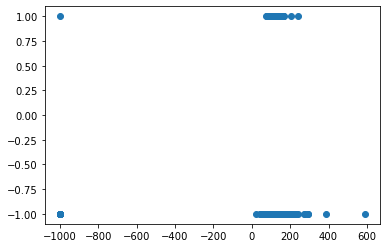

In [16]:
indices = np.arange(0, 250000, 1000)

xx = tx_train.T[0].T[indices]

yy = y_train[indices]

plt.scatter(xx, yy, marker='o')
plt.show()

# Binary classification

In [17]:
def standardize_data(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [18]:
tx_train = standardize_data(tx_train)
tx_test  = standardize_data(tx_test)

## Logistic Regression

In [31]:
N_test = len(y_test)

y_test = np.reshape(y_test, (N_test, 1))

In [32]:
N, D = tx_train.shape

y_train = np.reshape(y_train, (N, 1))
max_iter = 150
gamma = 0.1
initial_weights = np.zeros((D, 1))

weights, loss = logistic_regression(y_train, tx_train, initial_weights, max_iter, gamma)

print(f'Test loss: {calculate_loss(y_test, tx_test, weights)}')

Current iteration=0, loss=0.693147180559945
Current iteration=100, loss=0.15701615039582964
loss=0.09618928247245291
Test loss: 1.4844257445772375


1.4844257445772375


In [20]:
## Dunno how to visualize this

## Other ideas: hyperparameter search for gamma; OR gamma function that decreases over time

In [21]:
print(f'[Logistic Regression] In max_iter={max_iter}, with hyperparameter gamma={gamma} we obtain a loss={loss}')

[Logistic Regression] In max_iter=150, with hyperparameter gamma=0.1 we obtain a loss=0.09618928247245291


## Regularized Logistic Regression

## K-fold cross validation

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.
    
    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression for a fold corresponding to k_indices
    
    Args:
        y:          shape=(N,)
        x:          shape=(N,D)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()
        degree:     scalar, cf. build_poly()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)

    >>> cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)
    (0.019866645527597114, 0.33555914361295175)
    """
    
    N, D = x.shape

    # ***************************************************
    # get k'th subgroup in test, others in train
    # ***************************************************
    k_te_indices = k_indices[k]
    te_mask = np.zeros(N, dtype = bool)
    te_mask[k_te_indices] = True
    
    y_te = y[te_mask]
    y_tr = y[~te_mask]
    
    x_te = x[te_mask]
    x_tr = x[~te_mask]
    
    # ***************************************************
    # Regularized logistic regression
    # ***************************************************
    
    initial_weights = np.zeros((D, 1))
    gamma = 0.1
    max_iters = 150
    weights, loss = reg_logistic_regression(y_tr, x_tr, lambda_, initial_weights, max_iters, gamma)
    
    # ***************************************************
    # calculate the loss for train and test data
    # ***************************************************
    
    loss_tr = np.sqrt(2 * compute_mse(y_tr, x_tr, weights))
    loss_te = np.sqrt(2 * compute_mse(y_te, x_te, weights))
    
    return loss_tr, loss_te

def cross_validation_demo(y, x, k_fold, lambdas):
    """cross validation over regularisation parameter lambda.
    
    Args:
        degree: integer, degree of the polynomial expansion
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_rmse : scalar, the associated root mean squared error for the best lambda
    """
    
    seed = 12
    k_fold = k_fold
    lambdas = lambdas
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    # cross validation over lambdas
    # ***************************************************
    
    for lambda_ in lambdas:
        aux_tr = 0; aux_te = 0
        for k in np.arange(k_fold):
            loss_tr_tmp, loss_te_tmp = cross_validation(y, x, k_indices, k, lambda_)
            
            aux_tr += loss_tr_tmp
            aux_te += loss_te_tmp
            
        rmse_tr.append(aux_tr/k_fold)
        rmse_te.append(aux_te/k_fold)   

    ## Computing the best lambda & test rmse tuple
    best_idx = np.argmin(rmse_te)
    
    best_lambda = lambdas[best_idx]
    best_rmse   = rmse_te[best_idx]
        
    print("The choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f" % (best_lambda, best_rmse))
    return best_lambda, best_rmse

##Fn call
best_lambda, best_rmse = cross_validation_demo(y_train, tx_train, 4, np.logspace(-4, 0, 30))

In [ ]:
def best_param_selection(y, x, gammas, k_fold, lambdas, seed = 1):
    """cross validation over regularisation parameter lambda and gradient descent step gamma.
    
    Args:
        gammas: shape = (d,), where d is the number of values of gamma to test 
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_gamma  : scalar, value of the best gamma
        best_lambda : scalar, value of the best lambda
        best_rmse : value of the rmse for the couple (best_gamma, best_lambda)
    """
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # ***************************************************
    # cross validation over degrees and lambdas
    # ***************************************************
    
    rmse_matrix_tr = []
    rmse_matrix_te = []
    
    for lambda_ in lambdas:
        rmse_tr = []; rmse_te = []
        
        for degree in degrees:
            aux_tr = 0; aux_te = 0
            
            for k in np.arange(k_fold):
                loss_tr_tmp, loss_te_tmp = cross_validation(y, x, k_indices, k, lambda_, gamma)
            
                aux_tr += loss_tr_tmp
                aux_te += loss_te_tmp
            ##end for-k
            rmse_tr.append(aux_tr/k_fold)
            rmse_te.append(aux_te/k_fold)
        ##end for-deg
        rmse_matrix_tr.append(rmse_tr)
        rmse_matrix_te.append(rmse_te)
    ##end for-lambda
    
    best_idx = np.argmin(rmse_matrix_te)
    
    l_idx = best_idx // len(lambdas)
    d_idx = best_idx % len(degrees)
    
    best_lambda = lambdas[l_idx]
    best_degree = degrees[d_idx]
    best_rmse = rmse_matrix_te[l_idx][d_idx]
        
    return best_degree, best_lambda, best_rmse

In [34]:
lambda_ = 0.05
initial_weight = np.zeros((D,1))
gamma = 0.1
max_iter = 150

weights, loss = reg_logistic_regression(y_train, tx_train, lambda_, initial_weight, max_iter, gamma)

print(calculate_loss(y_test, tx_test, weights))

Current iteration=0, loss=0.693147180559945
Current iteration=100, loss=0.33620430535469925
loss=0.22785590913974219
1.0748463695319812


1.4771610607730876


In [23]:
print(f'[Reg. Logistic Regression] In max_iter={max_iter}, with hyperparameters lambda={lambda_} and gamma={gamma} we obtain a loss={loss} and a test loss={5} TODO')

[Reg. Logistic Regression] In max_iter=150, with hyperparameters lambda=0.0005 and gamma=0.1 we obtain a loss=0.09789751369434345 and a test loss=5 TODO
